# Credits to

[1] https://www.kaggle.com/mayer79/m5-forecast-keras-with-categorical-embeddings-v2 

[2] https://www.kaggle.com/ragnar123/very-fst-model

[3] https://www.kaggle.com/mayer79/m5-forecast-poisson-loss

# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import gc
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import time
import pickle
import lightgbm as lgb

# Reduce Memory Usage 

Run this function on dataframes to reduce the memory usage.

In [2]:
'''
Got from: [1]
'''
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Create file to store encoders

In [3]:
encoder_file = open('encoders', 'wb')

# Prepare Dataframes

In [4]:
'''
Got from: [1]
'''
path = "../input/m5-forecasting-accuracy"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

In [5]:
'''
Got from: [1]
- The columns "Date" and "Weekday" are dropped as they contain redundant information.
- Normally, the column "d" is like "d_1,d_2,...". Make it "1,2,.." and the type integer
- If there is no event (I think), there is NA. We will replace them with "NoEvent" string. Originally, it was replaced with
  "missing", but I don't think it makes sense as I don't think there is missing information, I think they just left 
  the days without any event as NA.
- We enumerate most of the columns:
    - We do not enumerate "d" and "wm_yr_weak" because we will use these columns for joins.
    - Why do we enumerate month and day? I think it is because they start from 1, not 0.
    - Originally, the binary columns "snap_X" were also enumerated. I don't think it is necessary. The only neccessary step
      was to convert their type from int64 to int as it uses less space; but reduce_mem_usage will take care of that.
- I would suggest saving the OrdinalEncoder in case we need to reverse the transformations
'''
def prep_calendar(df,encoder_file):
    df = df.drop(["date", "weekday"], axis=1)  
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("NoEvent")
    cols = list(set(df.columns) - {"wm_yr_wk", "d","snap_CA","snap_TX","snap_WI"}) 
    oe = OrdinalEncoder(dtype="int")
    df[cols] = oe.fit_transform(df[cols])
    pickle.dump(oe,encoder_file)
    df = reduce_mem_usage(df)
    return df

calendar = prep_calendar(calendar,encoder_file)

Mem. usage decreased to  0.03 Mb (85.4% reduction)


In [6]:
'''
Got from: [1]
Originally, there were features added in this part. I excluded them until we decide whether to use those or not.
'''
def prep_selling_prices(df):
    df = reduce_mem_usage(df)
    return df

selling_prices = prep_selling_prices(selling_prices)

Mem. usage decreased to 143.53 Mb (31.2% reduction)


In [7]:
'''
Got from: [1]
- We drop the first "drop_d" days. Originally, this is set to 1000. When it is set to this value,
  the shape we get 29,544,810 rows. When we don't set it, we get 60,034,810 rows. I think for now 
  we can keep this functionality, as it may be useful if we would like to discard some of the days.
- In some id's, we have "_validation". Those are deleted.
- reindex: Conform DataFrame to new index with optional filling logic (obtained from pandas doc). 
  We add days 1914+2*28 to prepare data from submission
- We have to melt the sales dataframe since days are contained as columns.
- assign: Returns a new object with all original columns in addition to new ones. Existing columns 
  that are re-assigned will be overwritten (obtained from pandas doc). Again, we make the values 
  "d_1, d-2,..." to "1,2,..."
'''
#We have to melt sales for sure because the days are columns, which is not desirable.

drop_d=730

def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"), demand=df.demand.astype("float32"))
    return df

sales = reshape_sales(sales, drop_d)

# Merge Dataframes

In [8]:
'''
Got from: [1]
- Merge all the dataframes and delete the unnecessary ones
- time.sleep() added to make sure garbage collector finishes its job before the next merge
'''
sales = sales.merge(calendar, how="left", on="d")
del calendar
gc.collect()
time.sleep(5)
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
del selling_prices
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
time.sleep(5)
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,731,0.0,2,0,2,19,2,3,1,0,0,0,NaN
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,731,0.0,2,0,2,19,2,3,1,0,0,0,3.97
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,731,0.0,2,0,2,19,2,3,1,0,0,0,NaN
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,731,1.0,2,0,2,19,2,3,1,0,0,0,4.34
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,731,0.0,2,0,2,19,2,3,1,0,0,0,3.08


# Encode some variables

In [9]:
'''
Got from: [1]
- We will also save the encoders in the pickle file.
- The loop is slightly changed
'''

cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]

# In loop to minimize memory use
for col in cat_id_cols:
    oe = OrdinalEncoder(dtype="int")
    sales[col] = oe.fit_transform(sales[[col]])
    pickle.dump(oe,encoder_file)    
sales = reduce_mem_usage(sales)
gc.collect()

Mem. usage decreased to 1513.14 Mb (44.7% reduction)


0

In [10]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,731,0.0,2,0,2,19,2,3,1,0,0,0,NaN
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,731,0.0,2,0,2,19,2,3,1,0,0,0,3.97
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,731,0.0,2,0,2,19,2,3,1,0,0,0,NaN
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,731,1.0,2,0,2,19,2,3,1,0,0,0,4.34
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,731,0.0,2,0,2,19,2,3,1,0,0,0,3.08


# Feature Engineering

When we do train,test, validation split; for some time we have to store all data twice to be able to divide the dataset. And every feature we add increases the size of the dataset drastically. Hence, if you have memory issues, I would suggest doing this part after splitting, even if it means we have to execute each line 3 times (for train,test,valid). And we have to be careful for the first few rows because these features sometimes depend on previous datapoints; which may be found in train set for first few rows of validation, for example.

KNN also may require some extra data storage. Moreover, in that case, this part can be even after KNN. This way, you can also use imputed selling prices to calculate your new features.

In [11]:
'''
Got from: [1]
- These features were originally added in prep_selling_prices function to the 
  selling_prices dataframe, which does not exist anymore. But we can use the same
  code to add these to sales dataframe as well as the columns are the same.
- New feature="sell_price_rel_diff"
  pct_change(): Computes the percentage change from the immediately previous row by default. (Obtained from pandas doc.)
  The two lines below adds the percentage of change of each item that is sold in the stores. Of course, for the
  first datapoint, there is no previous, so this code produces an NA. Since there are 3049x10=30490 different (item,store)
  pairs, this new column has 30490 NAs.
- New feature="sell_price_roll_sd7"
  Rolling standard deviation: Moving Standard Deviation is a statistical measurement of market volatility (Google). We check the
  past 7 days.
- New feature="sell_price_cumrel"
  I think this is cumulative related frequency. I am not sure and I did not understand it clearly. I think
  it is some kind of normalization, because we subtract the minimum and divide by max-min+1.
- It runs without problems, but the RAM gets almost filled up so it gives you a heart attack.
- No need to call reduce_mem_usage() after as I tried and it did not save any additional space.
'''

gr = sales.groupby(["store_id", "item_id"])["sell_price"]
sales["sell_price_rel_diff"] = gr.pct_change()
#sales["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())

del gr
gc.collect()

sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,731,0.0,2,0,2,19,2,3,1,0,0,0,NaN,NaN
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,731,0.0,2,0,2,19,2,3,1,0,0,0,3.97,NaN
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,731,0.0,2,0,2,19,2,3,1,0,0,0,NaN,NaN
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,731,1.0,2,0,2,19,2,3,1,0,0,0,4.34,NaN
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,731,0.0,2,0,2,19,2,3,1,0,0,0,3.08,NaN


In [12]:
LAGS = [7, 28]
WINDOWS = [7, 28]
FIRST = 1914
LENGTH = 28

def demand_features(df):
    """ Derive features from sales data and remove rows with missing values """
    
    for lag in LAGS:
        df[f'lag_t{lag}'] = df.groupby('id')['demand'].transform(lambda x: x.shift(lag)).astype("float32")
        for w in WINDOWS:
            df[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id')[f'lag_t{lag}'].transform(lambda x: x.rolling(w).mean()).astype("float32")
        
    return df

def demand_features_eval(df):
    """ Same as demand_features but for the step-by-step evaluation """
    out = df.groupby('id', sort=False).last()
    for lag in LAGS:
        out[f'lag_t{lag}'] = df.groupby('id', sort=False)['demand'].nth(-lag-1).astype("float32")
        for w in WINDOWS:
            out[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id', sort=False)['demand'].nth(list(range(-lag-w, -lag))).groupby('id', sort=False).mean().astype("float32")
    
    return out.reset_index()

In [13]:
'''
Got from: [1]
Appearantly, [1] derived the features from [2].

- The features include rolling means and standard deviations for different number of days.
  I think this is also a measure of market volatiliy.
- After this, original notebook deletes rows producing NAs. 'rolling_mean_t180' produces the most NAs as I
  believe the value of first 180 days will be NA because to compute this we need 180 days prior. I do not 
  know whether adding these features is so important to delete that much data. Hence, I will keep it for now.
  I think time ranges can also be changed.
'''

#gr = sales.groupby(["id"])["demand"]
#sales['lag_t28'] = gr.transform(lambda x: x.shift(28))
#sales['rolling_mean_t7'] = gr.transform(lambda x: x.shift(28).rolling(7).mean())
#sales['rolling_mean_t30'] = gr.transform(lambda x: x.shift(28).rolling(30).mean())
#sales['rolling_mean_t60'] = gr.transform(lambda x: x.shift(28).rolling(60).mean())
#sales['rolling_mean_t90'] = gr.transform(lambda x: x.shift(28).rolling(90).mean())
#sales['rolling_mean_t180'] = gr.transform(lambda x: x.shift(28).rolling(180).mean())
#sales['rolling_std_t7'] = gr.transform(lambda x: x.shift(28).rolling(7).std())
#sales['rolling_std_t30'] = gr.transform(lambda x: x.shift(28).rolling(30).std())


# lora's custom features

sales['price_max'] = gr.transform('max')
sales['price_min'] = gr.transform('min')
sales['price_std'] = gr.transform('std')
sales['price_mean'] =gr.transform('mean')
sales['price_norm'] = sales['sell_price']/sales['price_max']
sales['price_momentum'] =   sales['sell_price']/gr.transform(lambda x: x.shift(1))
sales['price_momentum_m'] = sales['sell_price']/gr.transform('mean')
sales['price_momentum_y'] = sales['sell_price']/gr.transform('mean')

#del gr
#sales = reduce_mem_usage(sales)
#gc.collect()


NameError: name 'gr' is not defined

In [14]:
sales = demand_features(sales)
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wday,month,...,snap_TX,snap_WI,sell_price,sell_price_rel_diff,lag_t7,rolling_mean_lag7_w7,rolling_mean_lag7_w28,lag_t28,rolling_mean_lag28_w7,rolling_mean_lag28_w28
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,731,0.0,2,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,731,0.0,2,0,...,0,0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,731,0.0,2,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,731,1.0,2,0,...,0,0,4.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,731,0.0,2,0,...,0,0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
sales = sales[sales.d > (drop_d + max(LAGS) + max(WINDOWS))]
#sales = sales.drop("sell_price_cumrel", axis=1)
sales = reduce_mem_usage(sales)
gc.collect()
sales.head()

Mem. usage decreased to 2407.91 Mb (0.0% reduction)


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wday,month,...,snap_TX,snap_WI,sell_price,sell_price_rel_diff,lag_t7,rolling_mean_lag7_w7,rolling_mean_lag7_w28,lag_t28,rolling_mean_lag28_w7,rolling_mean_lag28_w28
1707440,HOBBIES_1_001_CA_1,1437,3,1,0,0,787,0.0,2,2,...,0,0,NaN,NaN,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1707441,HOBBIES_1_002_CA_1,1438,3,1,0,0,787,0.0,2,2,...,0,0,3.97,0.0,0.0,0.000000,0.250000,0.0,0.285714,0.321429
1707442,HOBBIES_1_003_CA_1,1439,3,1,0,0,787,0.0,2,2,...,0,0,NaN,NaN,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1707443,HOBBIES_1_004_CA_1,1440,3,1,0,0,787,1.0,2,2,...,0,0,4.64,0.0,2.0,2.000000,1.821429,2.0,1.285714,1.178571
1707444,HOBBIES_1_005_CA_1,1441,3,1,0,0,787,2.0,2,2,...,0,0,3.08,0.0,0.0,1.428571,1.035714,4.0,1.285714,1.142857


In [16]:
from sklearn.model_selection import train_test_split


x = list(set(sales.columns) - {'id', 'd', 'demand'})

# Split into test, valid, train
test = sales[sales.d >= FIRST - max(LAGS) - max(WINDOWS)]
sales = sales[sales.d < FIRST]


xtrain, xvalid, ytrain, yvalid = train_test_split(sales[x], sales["demand"], test_size=0.1, shuffle=True, random_state=42)
del sales
gc.collect()

0

In [17]:
train_set = lgb.Dataset(xtrain, ytrain)
valid_set = lgb.Dataset(xvalid, yvalid)

# Train Test Split

Naming convention:
* test, train, valid -> Use these to create your X_{train,valid,test}  and y_{train,valid}.
* Training data: X_train, y_train
* Validation data: X_valid, y_valid
* Testing data (Kaggle has the labels): X_test

X_{train,valid,test} should be preprocessed according to your model.

Since we will use test dataframe for submission and the submission is obtained from another person, make sure the order of X_test and test is the same.

This process increases memory usage from 6GB to 7.5GB and reduce_mem_usage() does not improve the situation. One idea can be to keep the flags generated but produce end datasets at the end.

In [18]:
'''
Got from: [1]
'''
'''
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
gc.collect()

# One month of validation data
flag_valid = (sales.d < 1914) & (sales.d >= 1914 - 28)
valid = sales[flag_valid]
flag_train = sales.d < 1914 - 28
train = sales[flag_train]


del sales, flag_valid,flag_train
gc.collect()
time.sleep(5)

test.reset_index(drop=True)
valid.reset_index(drop=True)
train.reset_index(drop=True)

gc.collect()
'''

'\ntest = sales[sales.d >= 1914]\ntest = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),\n                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))\ngc.collect()\n\n# One month of validation data\nflag_valid = (sales.d < 1914) & (sales.d >= 1914 - 28)\nvalid = sales[flag_valid]\nflag_train = sales.d < 1914 - 28\ntrain = sales[flag_train]\n\n\ndel sales, flag_valid,flag_train\ngc.collect()\ntime.sleep(5)\n\ntest.reset_index(drop=True)\nvalid.reset_index(drop=True)\ntrain.reset_index(drop=True)\n\ngc.collect()\n'

In [19]:
'''
x = list(set(train.columns) - {'id', 'd', 'demand', 'sell_price_cumrel'})
train_part = train[train['year'] > 2]
del train
'''

"\nx = list(set(train.columns) - {'id', 'd', 'demand', 'sell_price_cumrel'})\ntrain_part = train[train['year'] > 2]\ndel train\n"

# Close encoder file

In [20]:
encoder_file.close()

# Model

** Enter description of the model here **

** Name your model "model" **

In [21]:
'''
train_set = lgb.Dataset(train_part.drop(['id', 'demand','sell_price_cumrel'], axis=1), label = train_part['demand'])
del train_part
valid_set = lgb.Dataset(valid.drop(['id', 'demand', 'sell_price_cumrel'],axis=1), label = valid['demand'])
del valid
'''

"\ntrain_set = lgb.Dataset(train_part.drop(['id', 'demand','sell_price_cumrel'], axis=1), label = train_part['demand'])\ndel train_part\nvalid_set = lgb.Dataset(valid.drop(['id', 'demand', 'sell_price_cumrel'],axis=1), label = valid['demand'])\ndel valid\n"

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.93716
[200]	valid_0's rmse: 2.33614
[300]	valid_0's rmse: 2.29779
[400]	valid_0's rmse: 2.27147
[500]	valid_0's rmse: 2.25846
[600]	valid_0's rmse: 2.24572
[700]	valid_0's rmse: 2.23747
[800]	valid_0's rmse: 2.23002
[900]	valid_0's rmse: 2.22296
[1000]	valid_0's rmse: 2.21687
[1100]	valid_0's rmse: 2.21241
[1200]	valid_0's rmse: 2.20882
[1300]	valid_0's rmse: 2.20438
[1400]	valid_0's rmse: 2.20141
[1500]	valid_0's rmse: 2.19811
[1600]	valid_0's rmse: 2.19505
[1700]	valid_0's rmse: 2.19313
[1800]	valid_0's rmse: 2.19003
[1900]	valid_0's rmse: 2.18804
[2000]	valid_0's rmse: 2.18464
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 2.18464


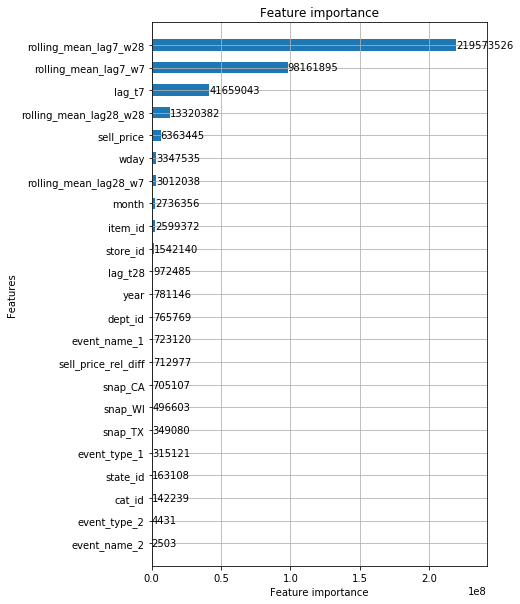

In [22]:
# taken from [3]
def fit_model(train, valid):
    """ Fit LightGBM model """
     
    params = {
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 200,
        'force_row_wise' : True,
        'learning_rate' : 0.075,
        #'lambda': 0.1,
        'num_leaves': 76,
        'sub_row' : 0.7,
        'bagging_freq' : 1,
        'colsample_bytree': 0.77,
        "lambda_l2" : 0.1,
    'verbosity': 1,
    #'num_iterations' : 1200,
    #"min_data_in_leaf": 100
    }

    fit = lgb.train(params, 
                    train, 
                    num_boost_round = 2000, # should be 2000
                    valid_sets = [valid], 
                    early_stopping_rounds = 200,
                    verbose_eval = 100)
    
    lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));
    
    return fit

fit = fit_model(train_set, valid_set)

In [23]:
# taken from [3]
'''
def pred_to_csv(fit, test, x, cols=sample_submission.columns, file="submission.csv"):
    """ Calculate predictions and append to submission csv """
    
    # Recursive prediction
    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
        test.loc[test.d == day, "demand"] = fit.predict(test_day[x]) * 1.03 # https://www.kaggle.com/kyakovlev/m5-dark-magic
    
    # Prepare for reshaping
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST + LENGTH, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + 1 - LENGTH * (test.d >= FIRST + LENGTH)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False)
    
    return True
pred_to_csv(fit, test, x)
'''

'\ndef pred_to_csv(fit, test, x, cols=sample_submission.columns, file="submission.csv"):\n    """ Calculate predictions and append to submission csv """\n    \n    # Recursive prediction\n    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):\n        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])\n        test.loc[test.d == day, "demand"] = fit.predict(test_day[x]) * 1.03 # https://www.kaggle.com/kyakovlev/m5-dark-magic\n    \n    # Prepare for reshaping\n    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST + LENGTH, "validation", "evaluation"),\n                       F="F" + (test.d - FIRST + 1 - LENGTH * (test.d >= FIRST + LENGTH)).astype("str"))\n    \n    # Reshape\n    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)\n    \n    # Export\n    submission.to_csv(file, index=False)\n    \n    return True\npred_to_csv(fit, test, x)\n'

# Submission

In [24]:
'''
Got from: [1]
'''
'''
pred = fit.predict(test.drop(['id', 'd', 'demand'],axis=1))
test["demand"] = pred.clip(0)
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission = sample_submission[["id"]].merge(submission, how="left", on="id")
submission.to_csv("submission.csv", index=False)
'''

'\npred = fit.predict(test.drop([\'id\', \'d\', \'demand\'],axis=1))\ntest["demand"] = pred.clip(0)\nsubmission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]\nsubmission = sample_submission[["id"]].merge(submission, how="left", on="id")\nsubmission.to_csv("submission.csv", index=False)\n'

In [25]:
def pred_to_csv(fit, test, x, cols=sample_submission.columns, file="submission.csv"):
    """ Calculate predictions and append to submission csv """
    
    # Recursive prediction
    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
        test.loc[test.d == day, "demand"] = fit.predict(test_day[x]) * 1.03 # https://www.kaggle.com/kyakovlev/m5-dark-magic
    
    # Prepare for reshaping
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST + LENGTH, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + 1 - LENGTH * (test.d >= FIRST + LENGTH)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False)
    
    return True

In [26]:
pred_to_csv(fit, test, x)

True